In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import importlib
plt.rcParams["font.family"] = "Times New Roman"

In [48]:
#input parameters

file = "77K_Section_A.xlsx"
sheets = ["9830"]
cols = ["WS_0","WS_1","WS_2","WS_3","WS_4","WS_5","WS_6","WS_7"]
start_index = 9830

In [49]:
#helper functions

def reduced_chi_squared(xdata, ydata, yerror, model, model_fit_parameters):
    dof = len(ydata)-model_fit_parameters
    theoretical = model(xdata,*model_fit_parameters)
    chi2 = np.sum(((ydata-theoretical)/yerror)**2)
    return chi2/dof

def wavelength_extraction(x, start_index):
    A = 0.9958
    alpha_A = 0.0001

    B = 9096.6280
    alpha_B = 0.0289

    wavelengths = []
    uncertainties = []

    for i in range(len(x)):
        wavelength = (start_index - 0.242*x[i] - B) / A
        uncertainty = np.abs((x[i] - (B + alpha_B)) / (A + alpha_A) - wavelength)

        wavelengths.append(wavelength)
        uncertainties.append(uncertainty)

    return wavelengths

def voigt_model_double(x, A1, center1, gamma1, sigma,
                                 A2, center2, gamma2, offset):
    return (
            A1 * voigt_profile(x - center1, sigma, gamma1) +
            A2 * voigt_profile(x - center2, sigma, gamma2) +
            offset
        )

In [50]:
########

#Pipeline

#Plan:
# 1) take the raw intensity data, produce a plot of intensity against wavelength
# 2) normalise all of the plots such that the area matches the area of one of them
# 3) fit a double voigt profile to an area of the dataset that I can specify (ensures we fit the R1 and R2 and not the other transitions)
# 4) produce the relevant summary statistcs
#########

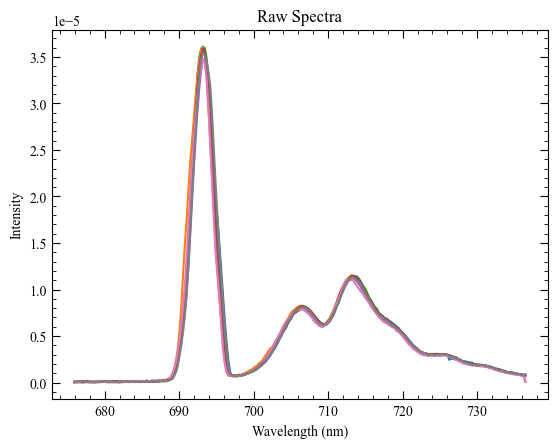

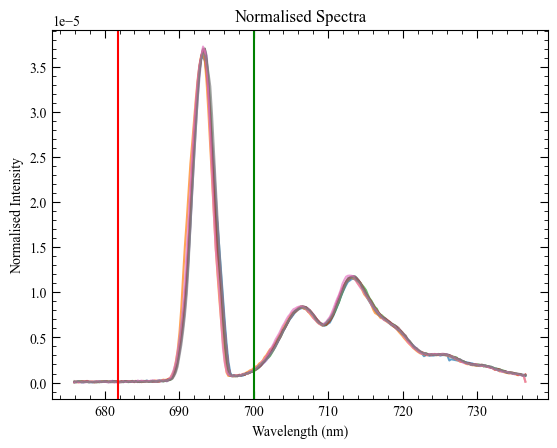

In [57]:
#implement step 1

#extract wavelengths
df = pd.read_excel(file,sheet_name = sheets[0])
index = np.arange(0, len(df[cols[0]]), 1)

wavelengths = wavelength_extraction(index, start_index)

#plot raw spectra
plt.figure(1)
for col in cols:
    plt.plot(wavelengths, df[col], label=col)

plt.title("Raw Spectra")
plt.ylabel("Intensity")
plt.xlabel("Wavelength (nm)")

plt.minorticks_on()
plt.tick_params(which='major', direction='in',
                    top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in',
                    top=True, bottom=True, left=True, right=True, size=3)

plt.show()

#normalise spectra such that the area matches that of the first column (step 2)

dx = np.abs(index[1] - index[0])
area_0 = np.sum(df[cols[0]]*dx)

normalised_spectra = []

plt.figure()
for col in cols:
    spectrum = df[col].to_numpy()
    norm_spec = (spectrum / np.sum(spectrum * dx)) * area_0
    normalised_spectra.append(norm_spec)
    plt.plot(wavelengths, norm_spec, alpha=0.7)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.ylabel("Normalised Intensity")
plt.title("Normalised Spectra")
plt.minorticks_on()
plt.tick_params(which='major', direction='in',
                    top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in',
                    top=True, bottom=True, left=True, right=True, size=3)

plt.axvline(wavelengths[225], color = 'red')
plt.axvline(wavelengths[150], color = 'green')
plt.show()

#create an averaged data frame for all of the spectra

intensity_matrix = np.column_stack(normalised_spectra)
intensity_data = np.mean(intensity_matrix, axis = 1)
intensity_error = np.std(intensity_matrix, axis = 1)/np.sqrt(len(cols))

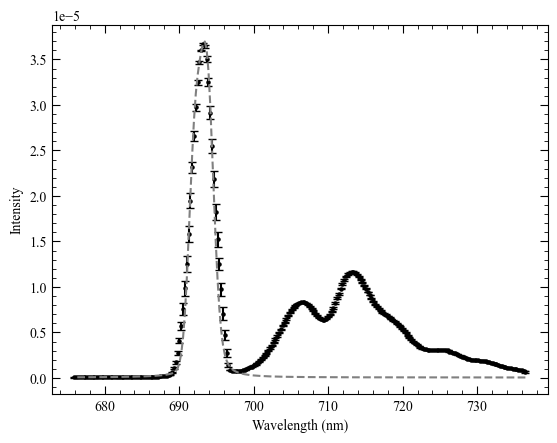

------ Summary Statistics ------


In [62]:
#implement step 3 (fitting the double voigt profile around R1 and R2):

padding = [150,225] #min max wavelength indexes

center2_guess = wavelengths[np.argmax(intensity_data)]
center1_guess = center2_guess - 1.4

p0_double = [
    intensity_data.max()/2, #Guess A1
    center1_guess, #center1
    0.3, #gamma1
    0.3, #sigma
    intensity_data.max()/2, #Guess A2
    center2_guess, #center2
    0.3, #gamma2
    np.min(intensity_data), #offset
]

bounds_double = [[
    0, #Guess A1
    wavelengths[padding[1]], #center1
    0, #gamma1
    0, #sigma
    0, #Guess A2
    wavelengths[padding[1]], #center2
    0, #gamma2
    -np.inf, #offset
],[
    np.inf, #Guess A1
    wavelengths[padding[0]], #center1
    np.inf, #gamma1
    np.inf, #sigma
    np.inf, #Guess A2
    wavelengths[padding[0]], #center2
    np.inf, #gamma2
    np.inf, #offset
]]

pop, cov = curve_fit(voigt_model_double,
                     xdata= wavelengths[padding[0]:padding[1]],
                     ydata= intensity_data[padding[0]:padding[1]],
                     sigma= intensity_error[padding[0]:padding[1]],
                     absolute_sigma=True,
                     p0 = p0_double,
                     bounds = bounds_double)

plt.figure(1)
plt.scatter(wavelengths, intensity_data, c='black', s = 5)
plt.errorbar(wavelengths, intensity_data, yerr = intensity_error, linestyle = "none", color = "black", capsize= 3)
plt.plot(wavelengths, voigt_model_double(wavelengths, *pop), color = "grey", linestyle = "--")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.minorticks_on()
plt.tick_params(which='major', direction='in',
                    top=True, bottom=True, left=True, right=True, size=6)
plt.tick_params(which='minor', direction='in',
                    top=True, bottom=True, left=True, right=True, size=3)

plt.show()

print(f"------ Summary Statistics ------")